To begin our data reduction, we need to load in several FITS files into Python-ready data structures. Using ```specsuite```, you can quickly load your calibration and science exposures into Numpy arrays! Let's do this for some sample data located on the GitHub repository...

In [1]:
import specsuite as ss

# Defines where to look for data
DATA_REGION = (700, 800)
CAL_PATH = "../data/KOSMOS/calibrations"
DATA_PATH = "../data/KOSMOS/target"
INSTRUMENT = "kosmos"

# Loads average of all 'bias' exposures
bias = ss.average_matching_files(
    path = CAL_PATH,
    tag = "bias",
    crop_bds = DATA_REGION,
    instrument = INSTRUMENT,
)

# Loads average of all 'flat' exposures
flat = ss.average_matching_files(
    path = CAL_PATH,
    tag = "flat",
    crop_bds = DATA_REGION,
    instrument = INSTRUMENT,
) - bias

# Loads average of all 'neon' exposures
arclamp = ss.average_matching_files(
    path = CAL_PATH,
    tag = "neon",
    crop_bds = DATA_REGION,
    instrument = INSTRUMENT,
) - bias

# Loads all 'toi3884' exposures as separate arrays
science = ss.collect_images_array(
    DATA_PATH,
    "toi3884",
    crop_bds=DATA_REGION,
    instrument = INSTRUMENT,
) - bias

We can use our flatfield exposure to perform a standard calibration on our data!

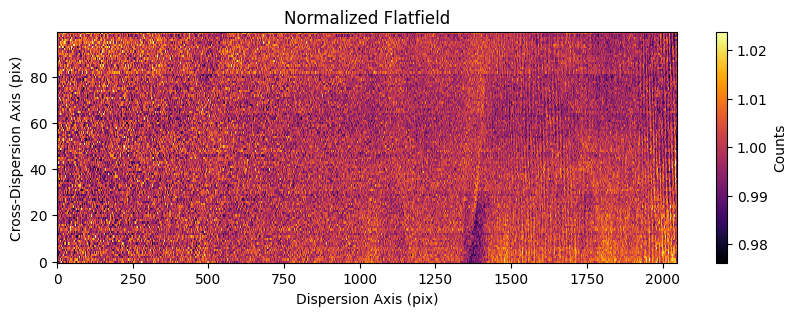

In [2]:
science = ss.flatfield_correction(
    image = science,
    flat = flat,
    debug = True,
)

Using ```specsuite```'s "warp models," we can come up with an approximate model for how light is warped on the detector.

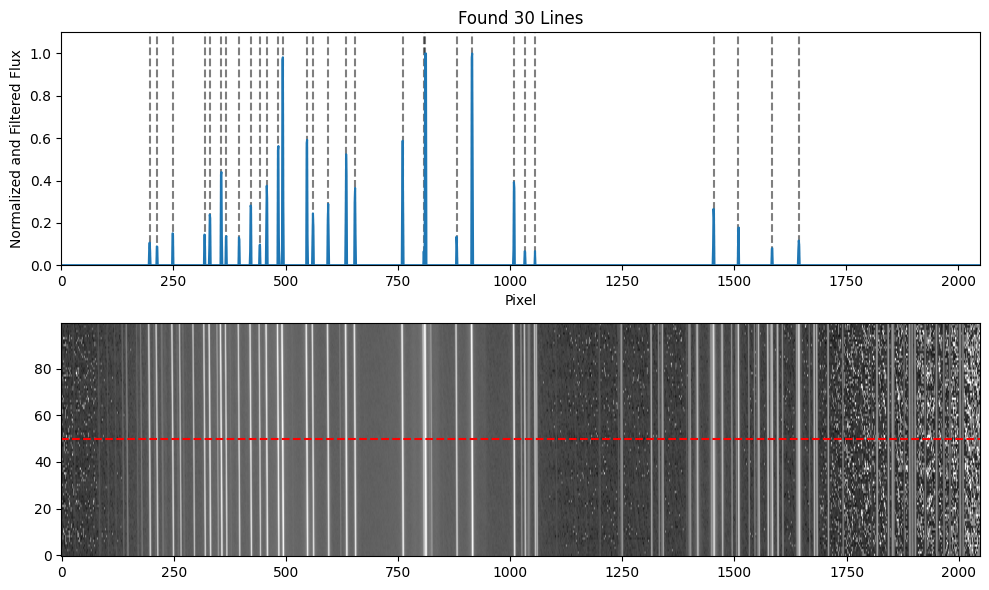

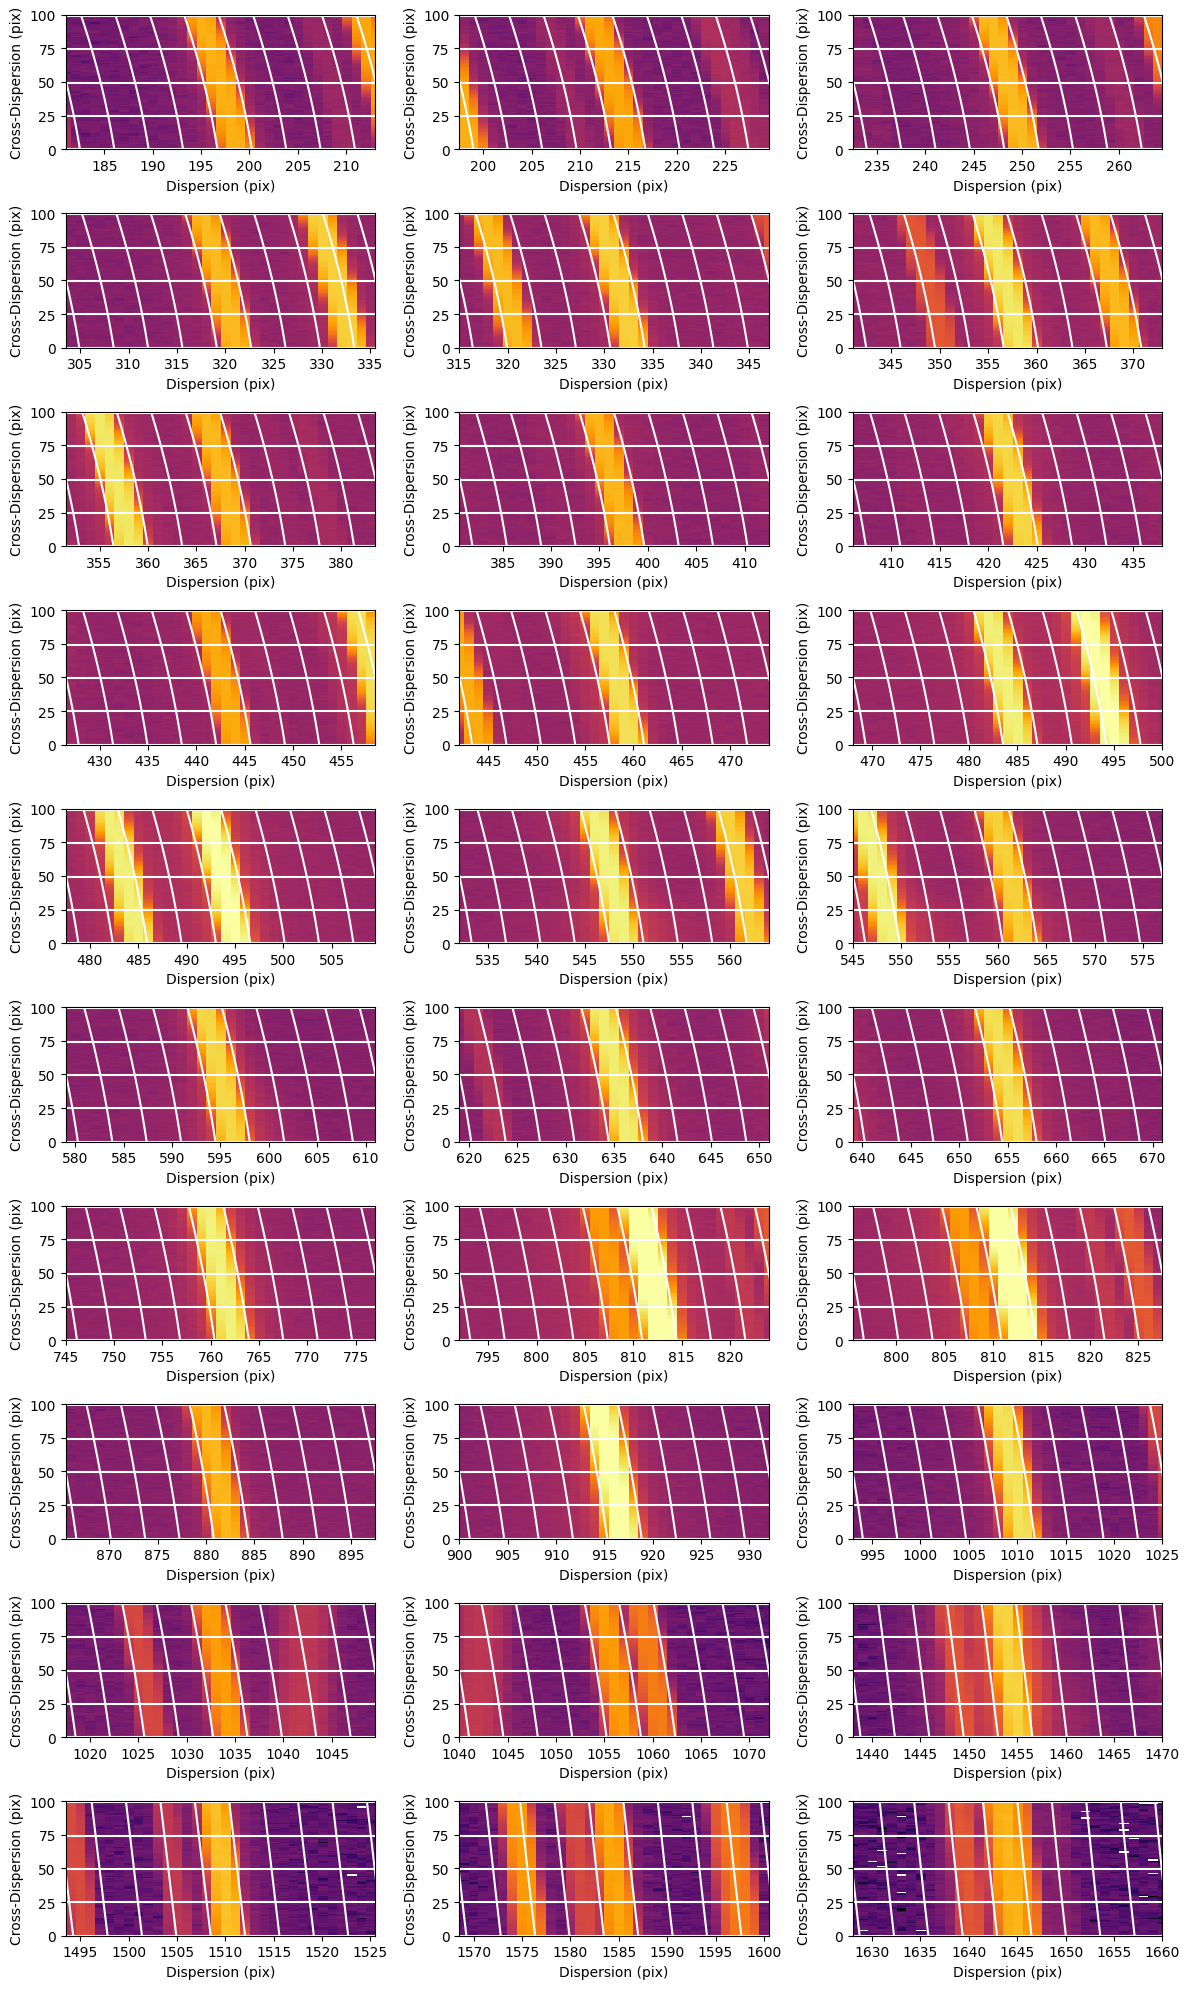

In [3]:
# Identifies the pixel positions of line emissions
locs, _ = ss.find_cal_lines(
    image = arclamp,
    std_variation = 200,
    debug = True,
)

# Models how line emissions are 'bent'
warp_model = ss.generate_warp_model(
    image = arclamp,
    guess = locs,
    debug = True,
)

This "warp model" can then be used to perform a high-quality background extraction!

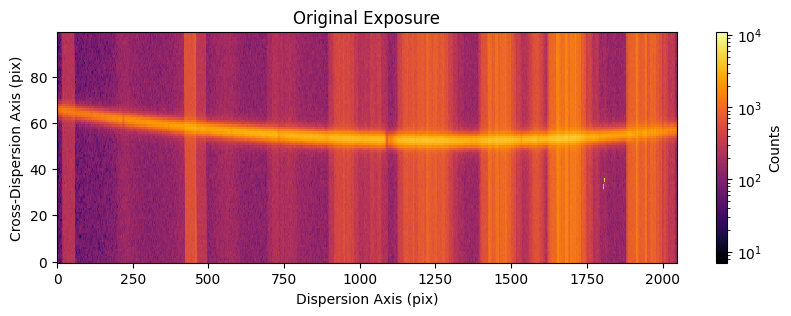

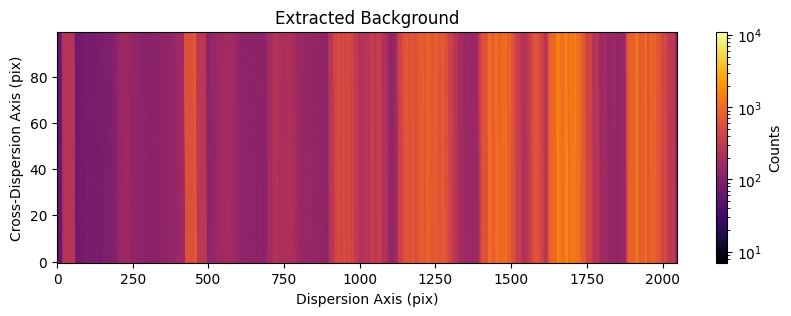

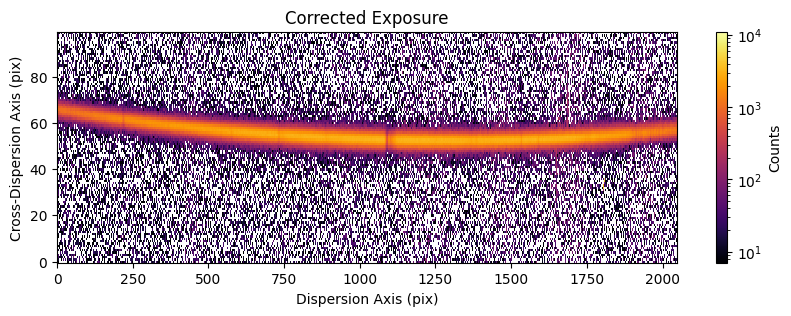

In [4]:
backgrounds = ss.extract_background(
    images = science,
    warp_model = warp_model,
    mask_region = (40, 80),
    debug = True,
)
calibrated_science = science - backgrounds

While there are several functions available for performing a flux extraction, we can use a simple boxcar extraction to get a quick look at our data.

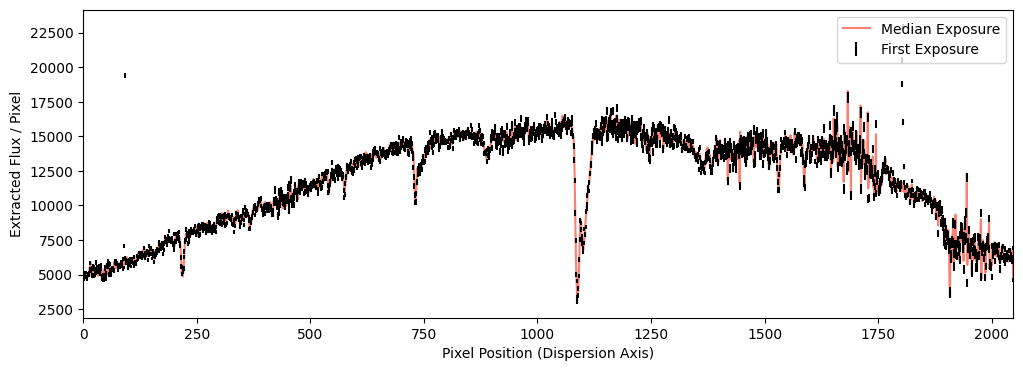

In [5]:
flux, error = ss.boxcar_extraction(
    images = calibrated_science,
    backgrounds = backgrounds,
    RN = 6.0,
    debug = True,
)

There is more ```specsuite``` has to offer, please take a look through the documentation to get an in-depth explanation of each of these steps (+ several additional tools)!